Dataset figure

(270, 480, 3)
(540, 960, 3)


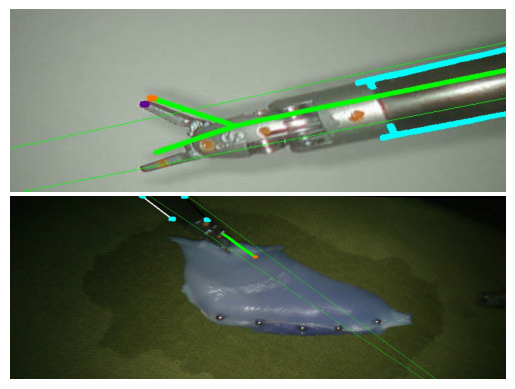

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


d1 = plt.imread('jrn_li.png')
d2 = plt.imread('dtd_endpi.png')

print(d1.shape)
print(d2.shape)

d1_cropped = d1[100:300, 115:400, :]
d2_cropped = d2[0:275, 225:510, :]

fig, ax = plt.subplots(nrows=2, ncols=1)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0].imshow(d1, aspect = 'auto') 
ax[0].axis('off')
ax[1].imshow(d2, aspect = 'auto')
ax[1].axis('off')

plt.subplots_adjust(hspace = 0.02)
plt.savefig('dataset_images.pdf', bbox_inches = 'tight')



Heatmap Figure

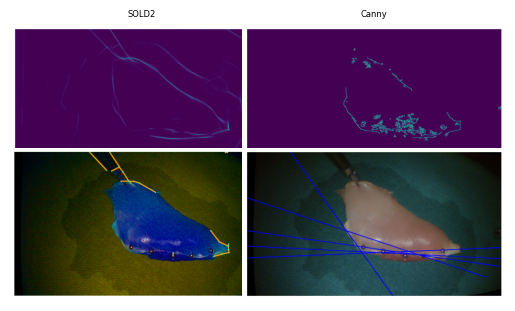

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


img1 = plt.imread('dtd_sold2lineheatmap.png')
img2 = plt.imread('dtd_sold2linedetection.png')

img3 = plt.imread('dtd_cannyedgedetection.png')
img4 = plt.imread('dtd_cannyedgelines.png')


fig, ax = plt.subplots(nrows=2, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
ax[0, 0].set_title('SOLD2', fontsize = 6)
ax[0, 1].imshow(img3)
ax[0, 1].axis('off')
ax[0, 1].set_title('Canny', fontsize = 6)
ax[1, 0].imshow(img2)
ax[1, 0].axis('off')
ax[1, 1].imshow(img4)
ax[1, 1].axis('off')

plt.subplots_adjust(hspace = -0.5, wspace = -0.12)
plt.savefig('shaft_detection.pdf', bbox_inches = 'tight')


Shaft detection figure

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# sold2 reference image
# sold2 associated image
# canny associated image 
d1 = plt.imread('jrn_canny.png')
d2 = plt.imread('dtd_endpi.png')

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].imshow(d1) 
ax[0].axis('off')
ax[1].imshow(d2)
ax[1].axis('off')

plt.subplots_adjust(hspace = 0.02)
plt.savefig('dataset_images.pdf', bbox_inches = 'tight')

JRN Dataset: 2D

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('ref_data/no_contour/keypoint_labels.csv', header = None, names = ['video_frame', 'x', 'y'])
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
labels.to_pickle('ref_data/no_contour/keypoint_labels.pkl')
labels = np.load('ref_data/no_contour/keypoint_labels.pkl', allow_pickle = True)

canny = pd.read_csv('ref_data/no_contour/canny_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi2p = pd.read_csv('ref_data/no_contour/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi = pd.read_csv('ref_data/no_contour/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi.drop(columns = ['t', 'video_frame'], inplace = True)
endp2p = pd.read_csv('ref_data/no_contour/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
li = pd.read_csv('ref_data/no_contour/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
li2p = pd.read_csv('ref_data/no_contour/line_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])

df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    df_list[i]['video_frame'] = np.arange(1, len(labels) + 2)
    df_list[i].drop(columns=['x_d', 'y_d'], inplace = True)
    column_name1 = 'x_' + df_names[i]
    df_list[i][column_name1] = df_list[i]['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df_list[i][column_name2] = df_list[i]['y'].copy()
    df_list[i].drop(columns=['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df_list[i], on = 'video_frame')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))
    


labels.head()
    


canny_d mean: 20.16777958358736, std: 12.713203102855624
endpi2p_d mean: 44.84362346436527, std: 13.27642167141603
endpi_d mean: 31.257088637746914, std: 10.91450786342805
endp2p_d mean: 26.94601080275629, std: 17.17348376783009
li_d mean: 30.391656688402975, std: 19.288853067521835
li2p_d mean: 23.873805366680497, std: 11.783180420075956


,video_frame,x,y,x_canny,y_canny,canny_d,x_endpi2p,y_endpi2p,endpi2p_d,x_endpi,...,endpi_d,x_endp2p,y_endp2p,endp2p_d,x_li,y_li,li_d,x_li2p,y_li2p,li2p_d
0,1,147.000000,152.105263,137,153,10.039948,115,163,33.803776,120,...,28.130533,140,150,7.309729,141,146,8.560037,119,162,29.696899
1,2,149.185185,152.444444,145,154,4.464922,115,165,36.417974,120,...,30.147329,144,148,6.829292,146,145,8.097231,118,166,34.003954
2,3,151.666667,153.500000,146,154,5.688683,116,165,37.474806,120,...,32.326889,145,148,8.642595,146,146,9.400059,116,166,37.793665
3,4,149.250000,153.750000,146,154,3.259601,115,165,36.050312,120,...,29.910283,145,148,7.150175,146,145,9.334077,115,166,36.374785
4,5,150.833333,153.500000,146,154,4.859127,115,165,37.633466,120,...,31.511021,145,148,8.017342,146,145,9.778093,114,166,38.896587


In [ ]:

df.drop(columns=['B', 'C'], inplace = True)

canny['d'] = np.sqrt((canny['x_p'] - canny['x_d'])**2 + (canny['y_p'] - canny['y_d'])**2)
canny['d_cumsum'] = canny['d'].cumsum()
endpi2p['d'] = np.sqrt((endpi2p['x_p'] - endpi2p['x_d'])**2 + (endpi2p['y_p'] - endpi2p['y_d'])**2)
endpi2p['d_cumsum'] = endpi2p['d'].cumsum()
endpi['d'] = np.sqrt((endpi['x_p'] - endpi['x_d'])**2 + (endpi['y_p'] - endpi['y_d'])**2)
endpi['d_cumsum'] = endpi['d'].cumsum()
endp2p['d'] = np.sqrt((endp2p['x_p'] - endp2p['x_d'])**2 + (endp2p['y_p'] - endp2p['y_d'])**2)
endp2p['d_cumsum'] = endp2p['d'].cumsum()
li['d'] = np.sqrt((li['x_p'] - li['x_d'])**2 + (li['y_p'] - li['y_d'])**2)
li['d_cumsum'] = li['d'].cumsum()
li2p['d'] = np.sqrt((li2p['x_p'] - li2p['x_d'])**2 + (li2p['y_p'] - li2p['y_d'])**2)
li2p['d_cumsum'] = li2p['d'].cumsum()

assert(len(canny) == len(endpi2p) == len(endpi) == len(li) == len(li2p))

plt.xlabel('Video Frame')
plt.ylabel('Error (px)')
plt.title('Projected vs. Associated Keypoint Error')
plt.plot(np.arange(len(canny)), canny['d'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(canny)), endpi2p['d'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(canny)), endpi['d'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(canny)), endp2p['d'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(canny)), li['d'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(canny)), li2p['d'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

In [ ]:
# turn labels into dataframe

import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('fei_ref_data/keypoint_labels_v2.csv', header = None, names = ['t', 'video_frame', 'x', 'y'])
df['t'] = df['t'].astype('int')
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
labels['t'].fillna(method = 'ffill', inplace = True)
labels['t'].fillna(method = 'bfill', inplace = True)
labels.to_pickle('fei_ref_data/keypoint_labels_v2.pkl')
labels.head()